In [1]:
try:
    import polars as pl
except ImportError:
    !pip install polars
    import polars as pl
    
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
era_data = pl.read_csv("./Data/Train/ERAIL DATABASE_1.csv", separator = ";", ignore_errors = True)
#era_data_austria = era_data.filter(pl.col("Country") == "Austria")
era_data = era_data.with_columns(
    pl.col("Date of occurrence").str.strptime(pl.Date),
    pl.col("Time of occurrence").str.strptime(pl.Time, "%H:%M:%S", strict = False).fill_null(
        pl.col("Time of occurrence").str.strptime(pl.Time, "%H:%M", strict = False)
    ),
    pl.col("Estimated total material costs").str.extract(r"(\d+(?:\s?\d+)*)", 1).str.replace_all(" ", "").cast(pl.Int64)
)

era_data = era_data.with_columns(
    pl.col("Date of occurrence").dt.month().alias("Month"),
    pl.col("Time of occurrence").dt.hour().alias("Departure Hour"),
    pl.col("Date of occurrence").dt.year().alias("Year")
)
era_data

Only received by email after ERAIL stopped to work,Report Type,Investigation Status,ERAIL Occurrence,Title,Reporting Body,Date of occurrence,Time of occurrence,Occurrence type,Occurrence description,Country,Location name,Railway System type,Line type,Location type,Movement type,RU involved,IM involved,Passenger fatalities,Staff fatalities,LC User fatalities,Unauthorised person fatalities,Other fatalities,Total fatalities,Passenger serious injuries,Staff serious injuries,LC User serious injuries,Unauth. person serious injuries,Other serious injuries,Total serious injuries,Estimated total material costs,Damage Description,Legal basis,Decision to investigate,N. of related Safety Recs,"Direct cause description (including causal and contributing factors, excluding those of systemic nature)","Underlying and root causes description (i.e. systemic factors, if any)",Month,Departure Hour,Year
str,str,str,str,str,str,date,time,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,str,str,i8,i8,i32
null,"""Final report""","""Closed""","""FI-135""","""Wrong-side signalling failure,…","""Accident Investigation Board o…",2002-06-29,08:33:00,"""Wrong-side signalling failure""","""Signal malfunctioning""","""Finland""","""Kouvola - Harju section of lin…","""Railway""","""0""","""Line""","""Long distance passenger train""","""VR Group Ltd""","""Finnish Rail Administration""",0,null,0,null,0,0,0,null,0,0,0,0,null,null,"""Other national rules/ regulati…",null,0,null,null,6,8,2002
null,"""Final report""","""Closed""","""NL-444""","""Train derailment, 30/04/2003, …","""The Dutch Safety Board""",2003-04-30,00:42:00,"""Train derailment""","""Derailment of a freight train …","""The Netherlands""","""Station Apeldoorn""","""Railway""","""0""","""Station""","""Freight train""","""Railion Nederland""","""ProRail""",0,null,0,null,0,0,0,null,0,0,0,0,null,"""A lot of wagons were destroyed…","""in light of Article 19 §1 of S…",null,0,null,null,4,0,2003
null,"""Final report""","""Closed""","""FI-134""","""Other, 15.4.2004, Kaukomarkkin…","""Accident Investigation Board o…",2004-04-15,17:31:00,"""Other""","""Three methanol carrying Russia…","""Finland""","""Kaukomarkkinat Oy's track at H…","""Railway""","""Multiple track""","""Marshalling yard""","""Shunting operation""","""VR Group Ltd""","""Finnish Rail Administration""",0,0,0,0,0,0,0,0,0,0,0,0,150000,"""Rolling stock: one secondary a…","""Other national rules/ regulati…","""26.4.2004""",2,"""The incident was caused by the…",null,4,17,2004
null,"""Final report""","""Closed""","""FI-45""","""Train derailment, 5/11/2004, P…","""Accident Investigation Board o…",2004-05-11,12:57:00,"""Train derailment""","""Two wagons derailed""","""Finland""","""Pieksämäki Railway Yard""","""Railway""","""Single track""","""Station""","""Freight train""","""VR Group Ltd""","""Finnish Rail Administration""",0,0,0,0,0,0,0,0,0,0,0,0,150000,"""Track was damaged over a dista…","""Other national rules/ regulati…",null,0,"""The wooden sleepers were in po…",null,5,12,2004
null,"""Final report""","""Closed""","""NL-168""","""Spad, 21/05/2004, Station Amst…","""The Dutch Safety Board""",2004-05-21,18:35:00,"""Spad""","""SPAD (an empty double decker t…","""The Netherlands""","""Station Amsterdam""","""Railway""","""0""","""Station""","""Long distance passenger train""","""NS passenger""","""ProRail""",0,0,0,0,0,0,19,0,0,0,0,19,null,"""The damage to the infrastructu…","""Other national rules/ regulati…",null,4,null,null,5,18,2004
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""X-ID""","""Notification""","""Open""","""BE-10567""","""Trains collision, 13/5/2024, S…","""NIB BE""",2024-05-13,11:10:00,"""Trains collision""","""Collision of a locomotive with…","""Belgium""","""Schaerbeek""","""Railway""","""Multiple track""","""Marshalling yard""","""Shunting operation""","""SNCB / NMBS""","""Infrabel""",0,0,0,0,0,0,0,0,0,0,0,0,150000,"""1/ Three SNCB/NMBS s

In [3]:
location = era_data.group_by("Location type").agg(
    pl.count("ERAIL Occurrence").alias("incident_count")
).sort("incident_count", descending = True)

location

Location type,incident_count
str,u32
"""Line""",1901
"""Station""",1644
"""Other""",99
"""Marshalling yard""",94
"""Siding""",37
…,…
"""Plzeňské městské dopravní podn…",1
"""Double track""",1
""" Station""",1


In [4]:
occurrence = era_data.group_by("Occurrence type").agg(
    pl.count("ERAIL Occurrence").alias("incident_count")
).sort("incident_count", descending = True)

occurrence

Occurrence type,incident_count
str,u32
"""Train derailment""",1205
"""Level crossing accident""",697
"""Trains collision""",381
"""Accident to persons caused by …",362
"""Trains collision with an obsta…",222
…,…
"""Broken rails and track buckles""",1
"""Collission with object""",1
"""Accident to person involving r…",1


In [5]:
station = era_data.filter(pl.col("Location type") == "Station")
name = station.group_by("Location name").agg(
    pl.count("ERAIL Occurrence").alias("incident_count")
).sort("incident_count", descending = True)
name

Location name,incident_count
str,u32
"""Dej Triaj""",7
"""Kolín station""",7
"""Turceni""",6
"""Bucuresti Triaj""",5
"""Ferencváros""",5
…,…
"""Carcasonne station (Aude)""",1
"""Huntingdon""",1
"""Ciolpani""",1


In [6]:
severity_impact = era_data.group_by(["Location type", "Occurrence type"]).agg(
    pl.count("ERAIL Occurrence").alias("incident_count"),
    pl.col("Total fatalities").sum().alias("total_fatalities"),
    pl.col("Total fatalities").mean().alias("avg_fatalities"),
    pl.col("Total serious injuries").sum().alias("total_injuries"),
    pl.col("Total serious injuries").mean().alias("avg_injuries"),
    pl.col("Estimated total material costs").sum().alias("total_material_costs"),
    pl.col("Estimated total material costs").mean().alias("avg_material_costs")
).sort(["avg_fatalities", "avg_injuries", "avg_material_costs"], descending = True)

severity_impact

Severity and Impact Analysis:


Location type,Occurrence type,incident_count,total_fatalities,avg_fatalities,total_injuries,avg_injuries,total_material_costs,avg_material_costs
str,str,u32,i64,f64,i64,f64,i64,f64
"""Station""","""Dangerous goods release""",1,0,null,0,null,0,null
"""Other""","""Accident to persons caused by …",20,28,1.4,14,0.7,600000,150000.0
"""Line""","""Level crossing accident""",573,737,1.286213,449,0.783595,108430957,292266.730458
"""Line""","""Trains collision""",147,178,1.210884,484,3.292517,53500000,481981.981982
"""Station""","""Railway vehicle movement event""",1,1,1.0,2,2.0,150000,150000.0
…,…,…,…,…,…,…,…,…
"""Line""","""Wrong-side signalling failure""",9,0,0.0,0,0.0,750000,125000.0
"""Station""","""Wrong-side signaling failure""",4,0,0.0,0,0.0,450000,112500.0
"""Line""","""Broken wheels or axles""",3,0,0.0,0,0.0,160784,80392.0


In [7]:
month = era_data.group_by("Month").agg(
    pl.count("ERAIL Occurrence").alias("incident_count")
).sort("incident_count", descending = True)

print("Incidents per Month:")
month

Incidents per Month:


Month,incident_count
i8,u32
7,369
6,339
2,337
1,331
11,322
…,…
3,303
10,301
5,300


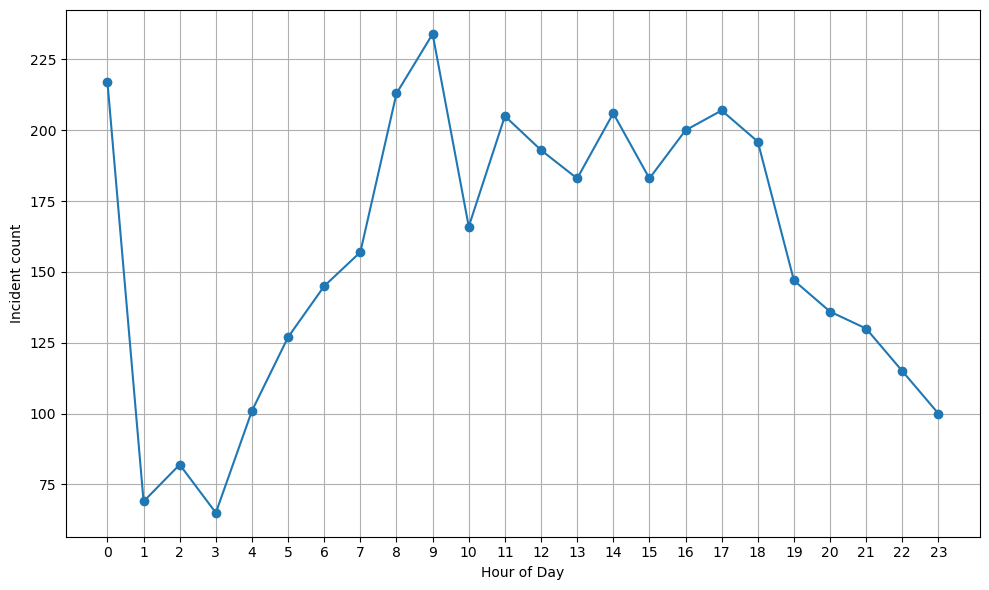

In [12]:
time = era_data.group_by("Departure Hour").agg(
    pl.count("ERAIL Occurrence").alias("incident_count")
).sort("Departure Hour")

plt.figure(figsize = (10,6))

plt.plot(time["Departure Hour"], time["incident_count"], marker = "o")

plt.xlabel("Hour of Day")
plt.ylabel("Incident count")
plt.xticks(range(0,24))
plt.grid(True)

plt.tight_layout()
plt.show()

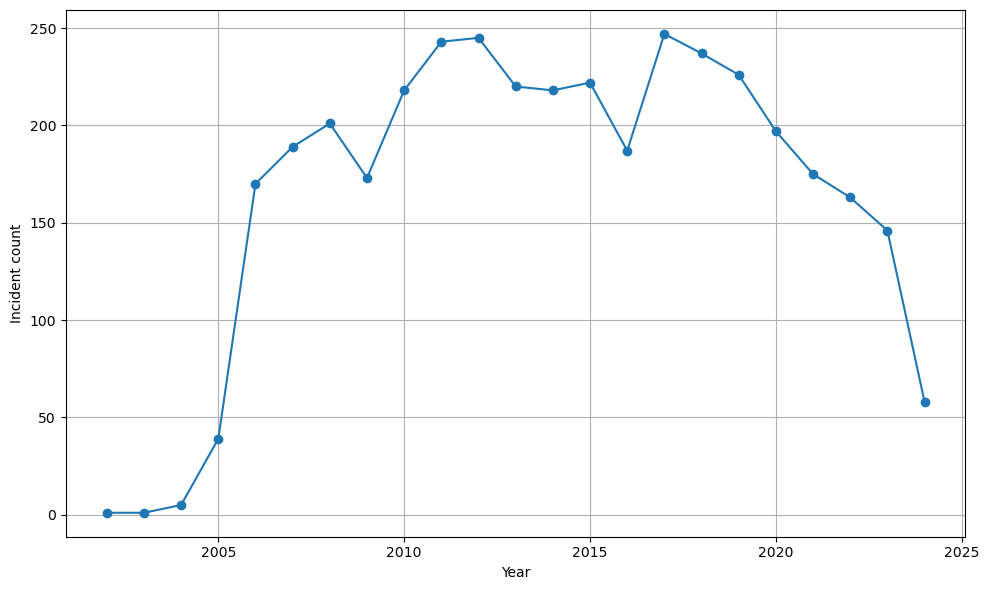

In [13]:
year = era_data.group_by("Year").agg(
    pl.count("ERAIL Occurrence").alias("incident_count")
).sort("Year", descending = True)

plt.figure(figsize = (10,6))

plt.plot(year["Year"], year["incident_count"], marker = "o")

plt.xlabel("Year")
plt.ylabel("Incident count")
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
direct_causes = era_data.group_by("Direct cause description (including causal and contributing factors, excluding those of systemic nature)").agg(
    pl.count("ERAIL Occurrence").alias("occurrence_count")
).sort("occurrence_count", descending = True)

print("Root Cause Analysis - Direct Causes:")
direct_causes

Root Cause Analysis - Direct Causes:


"Direct cause description (including causal and contributing factors, excluding those of systemic nature)",occurrence_count
str,u32
null,779
"""Human inattention.""",12
"""Direct cause: • driver's fail…",11
"""The victim crossed the level c…",9
"""Direct cause: • driver's fail…",6
…,…
"""Direct cause of the accident i…",1
"""Road users ignored the highway…",1
"""The accident is due to an infr…",1


In [15]:
underlying_causes = era_data.group_by("Underlying and root causes description (i.e. systemic factors, if any)").agg(
    pl.count("ERAIL Occurrence").alias("occurrence_count")
).sort("occurrence_count", descending = True)

print("Root Cause Analysis - Underlying/Root Causes:")
underlying_causes

Root Cause Analysis - Underlying/Root Causes:


"Underlying and root causes description (i.e. systemic factors, if any)",occurrence_count
str,u32
null,1422
""" """,293
"""none""",49
""".""",19
"""None""",14
…,…
"""Underlying cause: •failure to…",1
"""1) The inability of trucks and…",1
"""Not sufficient visibility due …",1
